In this notebook, we are going to perform a similar process to projecting skater fantasy points, but this time for goalies. Steps are mostly the same, with the main differences being the way fantasy points are calculated for goalies, and also the features used. There are a LOT less goalies than skaters in the NHL, and are much more volatile and difficult to predict in fantasy, especially since something like wins is majorly dependent on the team a goaltender is playing for.

Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score
import os
import psycopg2
from psycopg2.extras import execute_batch

Defining a function to load the data from specified file path (.xlsx created from webscraper).

In [2]:
# Load .xlsx scraped data from specified file path
def load_data(file_path):
    df = pd.concat(
        {sheet: pd.read_excel(file_path, sheet_name=sheet)
         for sheet in pd.ExcelFile(file_path).sheet_names},
        axis=0, names=['Season', 'Row']
    ).reset_index(level=0).rename(columns={'Season': 'Season'})
    print(f"Loaded data shape: {df.shape}")
    return df

Here, we define functions to preprocess the data. Luckily, the columns in the .xlsx do not have to be cleaned like the skaters data. All we are doing here is filtering by a minimum number of games, calculating the fantasy values for each player, and then creating a preprocessor to normalize the data and calculate scores from the past few years in order to better project a goalie's upcoming fantasy value.

In [3]:
# Remove players under minimum games from dataframe
def filter_data(df, min_games=15):
    """Preprocess the dataframe."""
    df = df[df['GP'] >= min_games]
    df['Season'] = pd.Categorical(df['Season']).codes
    return df

# This function calculates the fantasy points of a skater in a given season - the formula can be modified to preference, this is just the one I have went for
def calculate_fantasy_points(df):
    """Calculate total fantasy points for goalies."""
    df['FantasyPoints'] = (
        df['W'] * 3 + 
        df['GA'] * -1 + 
        df['SV'] * 0.2 + 
        df['SO'] * 2
    )
    df['FantasyPoints/G'] = df['FantasyPoints'] / df['GP']
    return df

# Create the lagging feature columns
def create_features(df): 
    lag_columns = ['GP', 'W', 'GAA', 'SV%', 'SOG', 'GA', 'SV', 'SO', 'FantasyPoints/G']
    for col in lag_columns:
        df[f'{col}_last_season'] = df.groupby('Name')[col].shift(1)
        df[f'{col}_2seasons_ago'] = df.groupby('Name')[col].shift(2)
    
    for col in lag_columns:
        df[f'{col}_yoy_change'] = df[col] - df[f'{col}_last_season']
    
    return df

# Adds lagging column features created by create_features to the total features, and then normalizes them
def create_preprocessor():
    numeric_features = ['Season', 'Age', 'GP', 'W', 'GAA', 'SV%', 'SOG', 'GA', 'SV', 'SO']
    
    lag_columns = ['GP', 'W', 'GAA', 'SV%', 'SOG', 'GA', 'SV', 'SO', 'FantasyPoints/G']
    for col in lag_columns:
        numeric_features.extend([f'{col}_last_season', f'{col}_2seasons_ago', f'{col}_yoy_change'])
    
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
        ])
    
    return preprocessor

Here, we define the dataset class and model architecture, once again similar to the skaters.

In [4]:
class NHLGoalieDataset(Dataset):
    def __init__(self, X, y=None):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32) if y is not None else None

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.y is not None:
            return self.X[idx], self.y[idx]
        return self.X[idx]

class NHLGoalieModel(nn.Module):
    def __init__(self, input_size, hidden_sizes=[256, 128, 64], dropout_rate=0.3):
        super(NHLGoalieModel, self).__init__()
        layers = []
        prev_size = input_size
        for hidden_size in hidden_sizes:
            layers.extend([
                nn.Linear(prev_size, hidden_size),
                nn.ReLU(),
                nn.BatchNorm1d(hidden_size),
                nn.Dropout(dropout_rate)
            ])
            prev_size = hidden_size
        layers.append(nn.Linear(prev_size, 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x).squeeze()

Here, we define the training model function. Once again, I manually messed with hyperparameters until I got a result I was happy with, but there are of course more optimized and better ways to go about this. The default values for the arguments in the function definition are the values I am happy with, though when running the function in main, you can specify a different value than the defaults.

In [5]:
def train_model(X, y, epochs=100, batch_size=16, learning_rate=0.0001, weight_decay=1e-5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    preprocessor = create_preprocessor()
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)
    
    train_dataset = NHLGoalieDataset(X_train_processed, y_train.values)
    test_dataset = NHLGoalieDataset(X_test_processed, y_test.values)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = NHLGoalieModel(input_size=X_train_processed.shape[1]).to(device)
    
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=20, factor=0.5, verbose=True)
    
    best_mae = float('inf')
    best_model = None
    patience = 50
    patience_counter = 0
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item()
        
        model.eval()
        val_loss = 0.0
        predictions = []
        actuals = []
        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                val_loss += criterion(outputs, batch_y).item()
                predictions.extend(outputs.cpu().numpy())
                actuals.extend(batch_y.cpu().numpy())
        
        mae = mean_absolute_error(actuals, predictions)
        r2 = r2_score(actuals, predictions)
        
        if mae < best_mae:
            best_mae = mae
            best_model = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
        
        scheduler.step(val_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss/len(train_loader):.4f}, '
                  f'Val Loss: {val_loss/len(test_loader):.4f}, MAE: {mae:.4f}, R²: {r2:.4f}')
        
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs")
            break
    
    model.load_state_dict(best_model)
    print(f"Best Model Performance - MAE: {best_mae:.4f}")
    
    return model, preprocessor

Here, we define the function to make the 2024-2025 projections for goalies, just like the skaters.

In [6]:
def make_projections(model, preprocessor, df):
    latest_season = df['Season'].max()
    projection_data = df[df['Season'] == latest_season].copy()
    
    features = [col for col in df.columns if col not in ['Name', 'Team', 'FantasyPoints/G']]
    X_proj = projection_data[features]
    X_proj['Season'] += 1
    
    X_proj_processed = preprocessor.transform(X_proj)
    projection_dataset = NHLGoalieDataset(X_proj_processed)
    projection_loader = DataLoader(projection_dataset, batch_size=32, shuffle=False)
    
    model.eval()
    device = next(model.parameters()).device
    
    with torch.no_grad():
        projections = []
        for batch_X in projection_loader:
            batch_X = batch_X.to(device)
            outputs = model(batch_X)
            projections.extend(outputs.cpu().numpy())
    
    projection_df = projection_data[['Name', 'Team']].copy()
    projection_df['ProjectedFantasyPoints/G'] = np.round(projections, 2)
    projection_df['ProjectedTotalFantasyPoints'] = np.round(projection_df['ProjectedFantasyPoints/G'] * 82, 2)
    
    return projection_df

Define functions to plot feature importance and model performance.

In [7]:
def visualize_feature_importance(model, preprocessor, X):
    feature_names = preprocessor.get_feature_names_out()
    importance = abs(model.model[0].weight.data.cpu().numpy()).mean(axis=0)
    
    feature_importance = pd.DataFrame({'feature': feature_names, 'importance': importance})
    feature_importance = feature_importance.sort_values('importance', ascending=False).head(20)

    plt.figure(figsize=(12, 8))
    sns.barplot(x='importance', y='feature', data=feature_importance)
    plt.title('Top 20 Feature Importance for Goalies')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

def visualize_model_performance(model, preprocessor, X, y):
    X_processed = preprocessor.transform(X)
    dataset = NHLGoalieDataset(X_processed, y.values)
    data_loader = DataLoader(dataset, batch_size=32, shuffle=False)
    
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for batch_X, batch_y in data_loader:
            batch_X = batch_X.to(next(model.parameters()).device)
            outputs = model(batch_X)
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(batch_y.numpy())
    
    mae = mean_absolute_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)
    
    # Scatter plot of predicted vs actual values
    plt.figure(figsize=(10, 6))
    plt.scatter(actuals, predictions, alpha=0.5)
    plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], 'r--', lw=2)
    plt.xlabel('Actual Fantasy Points/G')
    plt.ylabel('Predicted Fantasy Points/G')
    plt.title(f'Predicted vs Actual Fantasy Points/G for Goalies\nMAE: {mae:.2f}, R²: {r2:.2f}')
    plt.show()

Here is the main function where we call all of the previous functions and see how the model does! We also save the resulting Fantasy Points and Projected Fantasy Points into our postgres database for 2023-2024 goalies (I already altered the table with the new columns).

Loaded data shape: (1741, 18)


/tmp/ipykernel_8812/2615885019.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Season'] = pd.Categorical(df['Season']).codes
/mnt/c/Users/killi/Documents/Fantasy-Hockey-App/backend/venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [10/100], Train Loss: 14.4727, Val Loss: 14.7330, MAE: 3.7506, R²: -18.4418
Epoch [20/100], Train Loss: 11.2418, Val Loss: 11.3901, MAE: 3.2791, R²: -14.0308
Epoch [30/100], Train Loss: 7.1847, Val Loss: 6.9532, MAE: 2.5105, R²: -8.1862
Epoch [40/100], Train Loss: 3.6703, Val Loss: 3.2973, MAE: 1.6349, R²: -3.3559
Epoch [50/100], Train Loss: 2.0302, Val Loss: 1.1867, MAE: 0.8970, R²: -0.5754
Epoch [60/100], Train Loss: 1.6342, Val Loss: 0.7854, MAE: 0.7337, R²: -0.0401
Epoch [70/100], Train Loss: 1.5167, Val Loss: 0.6713, MAE: 0.6808, R²: 0.1088
Epoch [80/100], Train Loss: 1.3836, Val Loss: 0.6417, MAE: 0.6575, R²: 0.1494
Epoch [90/100], Train Loss: 1.2141, Val Loss: 0.6327, MAE: 0.6530, R²: 0.1580
Epoch [100/100], Train Loss: 1.2148, Val Loss: 0.6445, MAE: 0.6631, R²: 0.1452
Best Model Performance - MAE: 0.6399


/tmp/ipykernel_8812/4058996431.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_proj['Season'] += 1


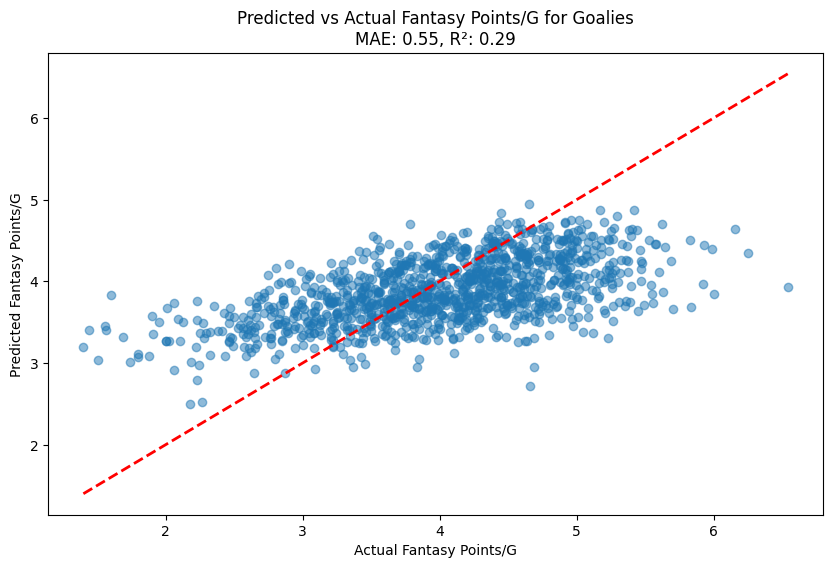

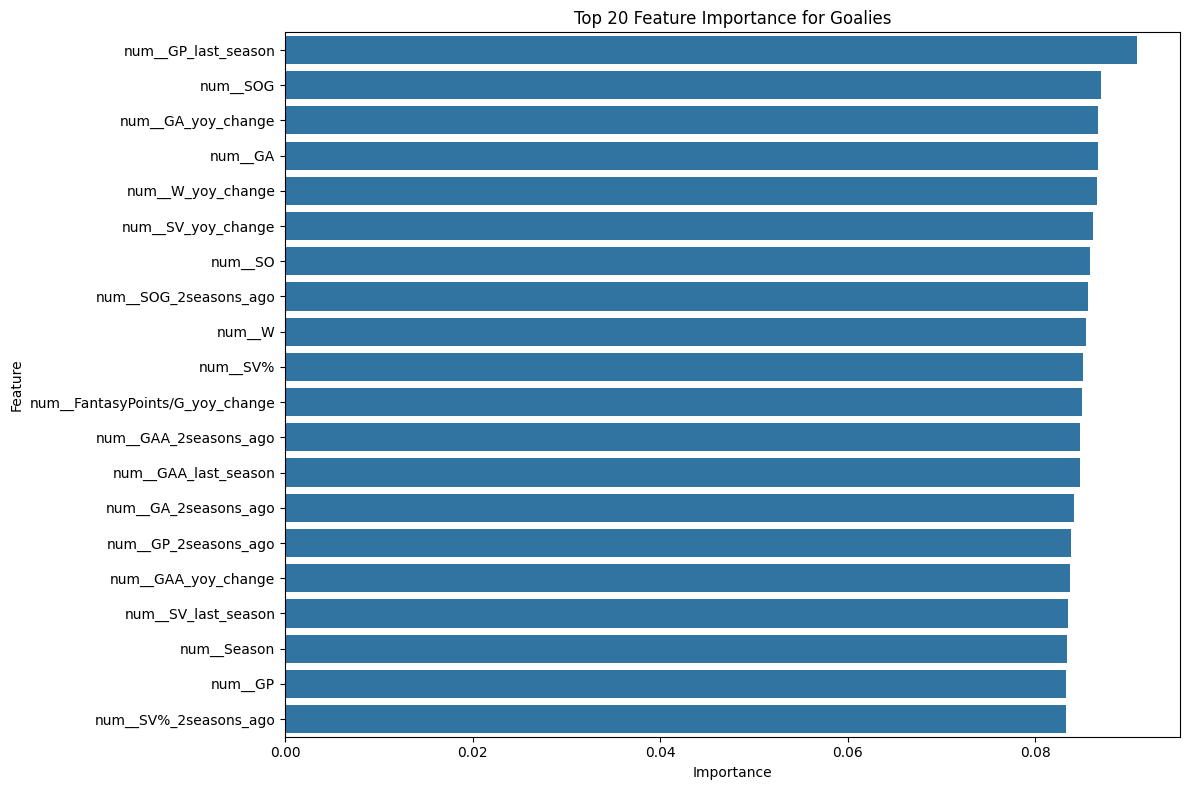

Changes committed to database


In [9]:
def main():
    goalie_file_path = '/mnt/c/Users/killi/Documents/Fantasy-Hockey-App/backend/webscraper/nhl_goalie_stats.xlsx'
    df_goalies = load_data(goalie_file_path)
    df_goalies = filter_data(df_goalies)
    df_goalies = calculate_fantasy_points(df_goalies)

    df_goalies = create_features(df_goalies)

    features = [col for col in df_goalies.columns if col not in ['Name', 'Team', 'FantasyPoints/G']]
    X_goalies = df_goalies[features]
    y_goalies = df_goalies['FantasyPoints/G'].shift(-1)

    # Remove rows where the target is NaN (last season for players who don't have multiple past seasons yet)
    mask_goalies = y_goalies.notna()
    X_goalies = X_goalies[mask_goalies]
    y_goalies = y_goalies[mask_goalies]

    model, preprocessor = train_model(X_goalies, y_goalies)
    projections_goalies = make_projections(model, preprocessor, df_goalies)

    visualize_model_performance(model, preprocessor, X_goalies, y_goalies)
    visualize_feature_importance(model, preprocessor, X_goalies)
    #projections_goalies.to_csv('goalie_projections.csv', index=False)

    db_username = os.getenv('DB_USERNAME')
    db_password = os.getenv('DB_PASSWORD')
    connection = psycopg2.connect(
        dbname='fantasy_hockey',
        user=db_username, # export DB_USERNAME='your_username'
        password=db_password, # export DB_PASSWORD='your_password'
        host='localhost'
    )
    cursor = connection.cursor()

    current_season = 18  # Numeric encoding for the 2023-2024 season
    current_season_str = '2023-24'
    season_mapping = {i: f"{2005+i}-{str(2006+i)[-2:]}" for i in range(19)}

    current_players = set(df_goalies[df_goalies['Season'] == current_season]['Name'])

    data_to_update = []
    for index, row in df_goalies.iterrows():
        name = row['Name']
        season_num = row['Season']
        
        season = season_mapping[season_num]
        
        if season_num == current_season:
            fantasy_points = round(float(row['FantasyPoints']), 2)
            projected_points = round(float(projections_goalies.loc[projections_goalies['Name'] == name, 'ProjectedTotalFantasyPoints'].values[0]), 2) if name in projections_goalies['Name'].values else 0.0
            data_to_update.append((fantasy_points, projected_points, name, season))

    query = """
        UPDATE goalie_stats
        SET fantasypoints = %s,
            projectedfantasypoints = %s
        WHERE Name = %s AND Season = %s
    """
    try:
        execute_batch(cursor, query, data_to_update)
    except Exception as e:
        print(f"Error during batch update: {e}")
        connection.rollback()
    else:
        connection.commit()

    # Set fantasy points and projected fantasy points to 0 for players not in the dataframe for the current season (< 15 games in 2023-2024)
    cleanup_query = """
        UPDATE goalie_stats
        SET fantasypoints = 0, projectedfantasypoints = 0
        WHERE Season = %s AND Name NOT IN %s
    """
    cursor.execute(cleanup_query, (current_season_str, tuple(current_players)))

    # Set fantasy points and projected fantasy points to 0 for all players where season is not 2023-2024
    cleanup_previous_seasons_query = """
        UPDATE goalie_stats
        SET fantasypoints = 0, projectedfantasypoints = 0
        WHERE Season != %s
    """
    cursor.execute(cleanup_previous_seasons_query, (current_season_str,))

    connection.commit()
    print("Changes committed to database")
    cursor.close()
    connection.close()

if __name__ == "__main__":
    main()

Based on the evaluation metrics, this model definitely performs worse than the skater model, which can be chalked up to three things: More volatility for goalies year over year, way less goalies than skaters, and only a subset of the features as skaters. With advanced stats, I believe the model performance could improve, but the results are solid due to the difficulty of these projections.